In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime as dt
#import geopandas as gpd
import json
import seaborn as sns
#from shapely.geometry import Point, Polygon
#from pyproj import CRS
#import plotly.graph_objects as go


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# import data

# bike rentals (https://data.london.gov.uk/dataset/number-bicycle-hires)
# metadata = pd.read_excel(Path.cwd().parent/"files"/"tfl-daily-cycle-hires.xlsx")
bike_rentals = pd.read_excel(Path.cwd().parent/"Assignment3"/"files"/"bike_rentals_london.xlsx", sheet_name = 'Data')

# covid (https://data.london.gov.uk/dataset/coronavirus--covid-19--cases)
covid = pd.read_csv(Path.cwd().parent/"Assignment3"/"files"/"corona_london.csv")

# weather (https://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-hourly-weather-obs/dataset-version-202107/greater-london/00697_london-st-jamess-park/qc-version-1)
# metadata od the weather data (https://artefacts.ceda.ac.uk/badc_datadocs/ukmo-midas/WH_Table.html)
li = []

for i in range(2010,2020,1):

    dummy = pd.read_csv(Path.cwd().parent/"Assignment3"/"files"/f"London_weather_{i}_heathrow.csv", header = 280)
    li.append(dummy)

weather = pd.concat(li, axis=0, ignore_index=True)

del li, dummy, i


C:\Users\lanab\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (93) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Preprocessing bike rental data

bike_rentals_month = bike_rentals[['Month', 'Number of Bicycle Hires.1', 'Average Hire Time (mins)']]
# drop NaN rows
bike_rentals_month = bike_rentals_month[bike_rentals_month['Number of Bicycle Hires.1'].notna()]

bike_rentals_year = bike_rentals[['Year', 'Number of Bicycle Hires.2']]
bike_rentals_year = bike_rentals_year.iloc[:bike_rentals_year.Year.isnull().values.argmax()]

bike_rentals = bike_rentals.drop(columns = ['Unnamed: 2', 'Unnamed: 5', 'Unnamed: 8', 'Month.1', 'Month', 'Number of Bicycle Hires.1', \
    'Average Hire Time (mins)', 'Year', 'Number of Bicycle Hires.2'])

bike_rentals.head()

,Day,Number of Bicycle Hires
0,2010-07-30,6897
1,2010-07-31,5564
2,2010-08-01,4303
3,2010-08-02,6642
4,2010-08-03,7966


In [4]:
# Preprocessing weather data

# drop columns with only zeros
weather = weather.dropna(axis=1, how='all')
# drop rows with only zeros
weather = weather.dropna(axis=0, how='all')
# drop columns version_num as all values = 1.0, id as all values = 3770 or NaN, met_domain_name as all values = SYNOP,
# id_type = WMO, 'src_id' = 697
weather = weather.drop(columns = ['version_num', 'id', 'met_domain_name', 'id_type', 'src_id'])
# drop columns wind_direction, wind_speed, wind_direction_q, wind_speed_q only two values in these columns
weather = weather.drop(columns = ['wind_direction', 'wind_speed', 'wind_direction_q', 'wind_speed_q'])
# drop column wind_speed_unit_id as all the wind columns consist of mostly NaNs
weather = weather.drop(columns = ['wind_speed_unit_id'])
# drop columns as the method and manner of measurement are not relevant for this analysis
weather = weather.drop(columns = ['rec_st_ind', 'src_opr_type', 'air_temperature_q', 'dewpoint_q', 'wetb_temp_q', 'dewpoint_j', \
    'wetb_temp_j', 'rltv_hum_j', 'midas_stmp_etime', 'meto_stmp_time'])
# drop columns where air_temperature = NaN
weather = weather[weather['air_temperature'].notna()]
# converting date to datetime
weather['ob_time'] = pd.to_datetime(weather['ob_time'])
# group by day to be able to merge it with the bike rental data
weather = weather.groupby(weather['ob_time'].dt.date).mean().reset_index()
weather['ob_time'] = pd.to_datetime(weather['ob_time'])

## optional
# drop columns where dewpoint, wetb_temp, rltv_hum = NaN -> needed if used for analysis, but if not rather more temperature measurements
weather = weather[weather['dewpoint'].notna()]

## checks
# NaN check 
weather.isna().sum()

ob_time                  0
prst_wx_id             821
cld_ttl_amt_id          43
cld_base_ht             43
visibility               2
msl_pressure             0
cld_amt_id_1           118
cld_base_ht_id_1       118
cld_amt_id_2           640
cld_base_ht_id_2       640
cld_amt_id_3          2171
cld_base_ht_id_3      2170
air_temperature          0
dewpoint                 0
wetb_temp                0
rltv_hum                 0
stn_pres                 0
alt_pres               519
q10mnt_mxgst_spd      2798
cavok_flag             526
wmo_hr_sun_dur          10
snow_depth            3609
prst_wx_id_q           821
cld_ttl_amt_id_q        43
cld_base_ht_q           43
visibility_q             2
msl_pressure_q           0
cld_amt_id_1_q         118
cld_base_ht_id_1_q     118
cld_amt_id_2_q         640
cld_base_ht_id_2_q     640
cld_amt_id_3_q        2171
cld_base_ht_id_3_q    2170
stn_pres_q               0
alt_pres_q             519
q10mnt_mxgst_spd_q    2798
wmo_hr_sun_dur_q        10
s

In [5]:
# Preprocessing covid data

# drop all dates without age information
covid = covid[covid.age_band != 'unassigned']
# drop columns area_name, area_code
covid = covid.drop(columns = ['area_name', 'area_code'])
# converting date to datetime
covid['date'] = pd.to_datetime(covid['date'])

In [6]:
# Preprocessing combing bike rentals and weather data by joining on the datetime

bike_rentals_weather = pd.merge(bike_rentals, weather, left_on='Day', right_on='ob_time')

In [7]:
# Preprocessing combing bike rentals and covid data by joining on the datetime

bike_rentals_covid = pd.merge(bike_rentals, covid, left_on='Day', right_on='date')

In [8]:
bike_rentals_weather

,Day,Number of Bicycle Hires,ob_time,prst_wx_id,cld_ttl_amt_id,cld_base_ht,visibility,msl_pressure,cld_amt_id_1,cld_base_ht_id_1,cld_amt_id_2,cld_base_ht_id_2,cld_amt_id_3,cld_base_ht_id_3,air_temperature,dewpoint,wetb_temp,rltv_hum,stn_pres,alt_pres,q10mnt_mxgst_spd,cavok_flag,wmo_hr_sun_dur,snow_depth,prst_wx_id_q,cld_ttl_amt_id_q,cld_base_ht_q,visibility_q,msl_pressure_q,cld_amt_id_1_q,cld_base_ht_id_1_q,cld_amt_id_2_q,cld_base_ht_id_2_q,cld_amt_id_3_q,cld_base_ht_id_3_q,stn_pres_q,alt_pres_q,q10mnt_mxgst_spd_q,wmo_hr_sun_dur_q,snow_depth_q,drv_hr_sun_dur,drv_hr_sun_dur_q
0,2010-07-30,6897,2010-07-30,52.000000,5.500000,123.750000,1883.333333,1014.687500,5.095238,123.000000,4.900000,213.000000,5.666667,290.0,17.558333,10.479167,13.741667,64.450000,1011.712500,1014.541667,NaN,6.50,0.130435,NaN,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.0,NaN,6.0,NaN,0.162500,1.0
1,2010-07-31,5564,2010-07-31,39.750000,5.291667,102.083333,2919.583333,1011.554167,4.318182,119.727273,5.111111,170.000000,5.000000,75.0,19.858333,13.708333,16.358333,69.808333,1008.612500,1011.458333,NaN,6.75,0.204348,NaN,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.0,NaN,6.0,NaN,0.200000,1.0
2,2010-08-01,4303,2010-08-01,23.000000,7.208333,156.666667,2879.166667,1013.225000,5.750000,172.625000,7.142857,333.857143,NaN,NaN,18.795833,11.125000,14.591667,62.675000,1010.266667,1013.041667,NaN,4.75,0.017391,NaN,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,NaN,NaN,6.0,1.0,NaN,6.0,NaN,0.041667,1.0
3,2010-08-02,6642,2010-08-02,42.333333,6.500000,173.333333,2470.833333,1016.791667,4.695652,204.000000,6.800000,288.000000,NaN,NaN,18.837500,10.483333,14.304167,59.066667,1013.833333,1016.666667,NaN,4.75,0.091304,NaN,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,NaN,NaN,6.0,1.0,NaN,6.0,NaN,0.095833,1.0
4,2010-08-03,7966,2010-08-03,NaN,4.666667,177.083333,1908.333333,1015.687500,4.888889,196.166667,5.666667,317.500000,6.000000,420.0,17.870833,11.225000,14.225000,66.145833,1012.729167,1015.583333,NaN,5.50,0.169565,NaN,NaN,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.0,NaN,6.0,NaN,0.191667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3437,2019-12-27,11718,2019-12-27,7.000000,7.541667,27.083333,1799.583333,1028.804167,7.250000,31.250000,5.500000,84.000000,NaN,NaN,7.291667,5.516667,6.500000,88.387500,1025.695833,NaN,NaN,NaN,0.000000,NaN,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,NaN,NaN,6.0,NaN,NaN,6.0,NaN,0.004167,1.0
3438,2019-12-28,11414,2019-12-28,12.222222,7.958333,25.416667,1532.083333,1036.316667,7.375000,32.125000,5.500000,27.000000,7.000000,30.0,8.208333,6.550000,7.437500,89.241667,1033.162500,NaN,NaN,NaN,0.000000,NaN,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,NaN,NaN,6.0,NaN,0.000000,1.0
3439,2019-12-29,12256,2019-12-29,8.800000,6.166667,72.291667,1651.666667,1033.554167,6.590909,91.909091,5.000000,525.000000,NaN,NaN,7.404167,5.158333,6.404167,85.612500,1030.408333,NaN,NaN,NaN,0.091304,NaN,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,NaN,NaN,6.0,NaN,NaN,6.0,NaN,0.116667,1.0
3440,2019-12-30,16166,2019-12-30,15.250000,4.250000,118.181818,781.666667,1029.683333,6.500000,10.250000,7.000000,9.000000,NaN,NaN,6.808333,5.695833,6.295833,93.158333,1026.550000,NaN,NaN,NaN,0.152174,NaN,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,NaN,NaN,6.0,NaN,NaN,6.0,NaN,0.141667,1.0


In [9]:
bins= [0.0,15.0,30.0,60.0,91.0]
labels = ['Child','Young Adult','Middle-Age Adult','Senior-Citizen']
bike_rentals_covid['AgeGroup'] = pd.cut(bike_rentals_covid['age_lower'], bins=bins, labels=labels, right=False)

In [10]:
bike_rentals_covid = bike_rentals_covid.drop(["age_band"], axis=1)

In [11]:
bike_rentals_covid

,Day,Number of Bicycle Hires,date,cases,rolling_sum,rolling_rate,age_lower,age_higher,population,AgeGroup
0,2020-02-03,28267,2020-02-03,0,0,0.0,0.0,4.0,595799.0,Child
1,2020-02-03,28267,2020-02-03,0,0,0.0,5.0,9.0,606333.0,Child
2,2020-02-03,28267,2020-02-03,0,0,0.0,10.0,14.0,550753.0,Child
3,2020-02-03,28267,2020-02-03,0,0,0.0,15.0,19.0,474456.0,Young Adult
4,2020-02-03,28267,2020-02-03,1,0,0.0,20.0,24.0,556594.0,Young Adult
...,...,...,...,...,...,...,...,...,...,...
13846,2022-01-31,26806,2022-01-31,174,1057,376.9,70.0,74.0,280432.0,Senior-Citizen
13847,2022-01-31,26806,2022-01-31,118,695,353.8,75.0,79.0,196419.0,Senior-Citizen
13848,2022-01-31,26806,2022-01-31,79,447,296.1,80.0,84.0,150980.0,Senior-Citizen
13849,2022-01-31,26806,2022-01-31,43,255,271.8,85.0,89.0,93808.0,Senior-Citizen


<AxesSubplot:title={'center':'cases'}, xlabel='AgeGroup'>

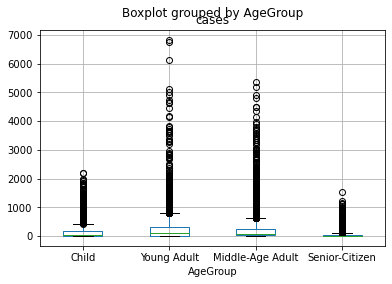

In [12]:
bike_rentals_covid.boxplot('cases','AgeGroup')

In [13]:
bike_rentals_covid['year']=bike_rentals_covid.Day.dt.year
bike_rentals_covid['pickup_date']=bike_rentals_covid.Day.dt.date
bike_rentals_covid['pickup_day']=bike_rentals_covid.Day.dt.day_name()
bike_rentals_covid['pickup_month']=bike_rentals_covid.Day.dt.month

# Extracting the day of the week (dow)
bike_rentals_covid['pickup_dow'] = pd.to_datetime(bike_rentals_covid['Day']).dt.dayofweek

# Type of day column
bike_rentals_covid['pickup_weekend'] = bike_rentals_covid.Day.dt.dayofweek.apply(lambda x: 'Saturday' if x <5 else 'Sunday')

In [14]:
# Adding the season
bike_rentals_covid['season']=bike_rentals_covid.Day.dt.month.apply(lambda x: 'Winter' if x <=2 else 'Spring' if x<=5 else 'Summer' 
                                             if x<=8 else 'Autumn' if x<=11 else 'Winter')

In [15]:
bike_rentals_covid = bike_rentals_covid.drop(["Day","date"], axis=1)

In [16]:
bike_rentals_covid

,Number of Bicycle Hires,cases,rolling_sum,rolling_rate,age_lower,age_higher,population,AgeGroup,year,pickup_date,pickup_day,pickup_month,pickup_dow,pickup_weekend,season
0,28267,0,0,0.0,0.0,4.0,595799.0,Child,2020,2020-02-03,Monday,2,0,Saturday,Winter
1,28267,0,0,0.0,5.0,9.0,606333.0,Child,2020,2020-02-03,Monday,2,0,Saturday,Winter
2,28267,0,0,0.0,10.0,14.0,550753.0,Child,2020,2020-02-03,Monday,2,0,Saturday,Winter
3,28267,0,0,0.0,15.0,19.0,474456.0,Young Adult,2020,2020-02-03,Monday,2,0,Saturday,Winter
4,28267,1,0,0.0,20.0,24.0,556594.0,Young Adult,2020,2020-02-03,Monday,2,0,Saturday,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13846,26806,174,1057,376.9,70.0,74.0,280432.0,Senior-Citizen,2022,2022-01-31,Monday,1,0,Saturday,Winter
13847,26806,118,695,353.8,75.0,79.0,196419.0,Senior-Citizen,2022,2022-01-31,Monday,1,0,Saturday,Winter
13848,26806,79,447,296.1,80.0,84.0,150980.0,Senior-Citizen,2022,2022-01-31,Monday,1,0,Saturday,Winter
13849,26806,43,255,271.8,85.0,89.0,93808.0,Senior-Citizen,2022,2022-01-31,Monday,1,0,Saturday,Winter


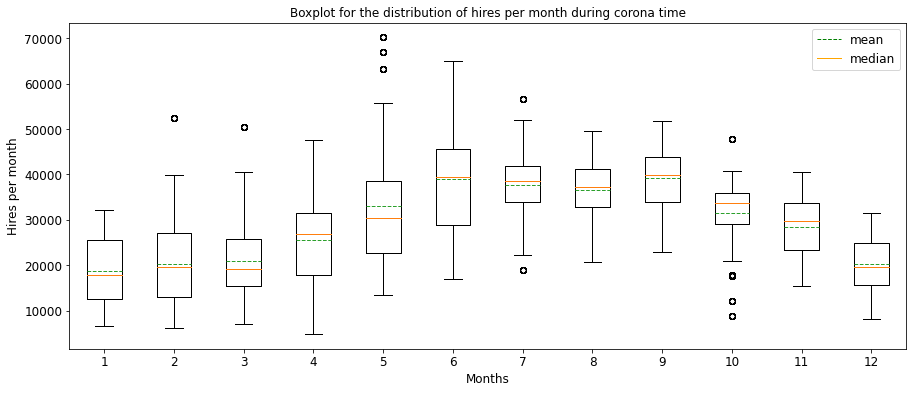

In [17]:
figure = plt.figure(figsize =(15, 6))
bikes_month=[]
for i in range(1,13):
    bikes_month.append(bike_rentals_covid[bike_rentals_covid['pickup_month']==i]['Number of Bicycle Hires'])
# Creating plot
plt.boxplot(bikes_month, showmeans=True, meanline= True)
plt.plot([], [], '--', linewidth=1, color='Green', label='mean')
plt.plot([], [], '-', linewidth=1, color='orange', label='median')
plt.xlabel("Months", fontsize=12)
plt.ylabel("Hires per month", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.title("Boxplot for the distribution of hires per month during corona time")
plt.show()

In [18]:
covid_hires_per_season=bike_rentals_covid.groupby(['pickup_dow','season']).mean()['Number of Bicycle Hires'].reset_index()

In [19]:
covid_hires_per_season

,pickup_dow,season,Number of Bicycle Hires
0,0,Autumn,30097.538462
1,0,Spring,24130.703704
2,0,Summer,33763.518519
3,0,Winter,17984.000000
4,1,Autumn,33323.846154
5,1,Spring,24139.384615
6,1,Summer,37872.703704
7,1,Winter,19339.920000
8,2,Autumn,34065.576923
9,2,Spring,23301.500000


In [20]:
covid_hires_per_dow=bike_rentals_covid.groupby(['pickup_dow','pickup_weekend']).mean()['Number of Bicycle Hires'].reset_index()
covid_hires_per_dow

,pickup_dow,pickup_weekend,Number of Bicycle Hires
0,0,Saturday,26621.714286
1,1,Saturday,28847.163462
2,2,Saturday,28816.971154
3,3,Saturday,28499.365385
4,4,Saturday,29066.423077
5,5,Sunday,33551.682692
6,6,Sunday,29895.961538


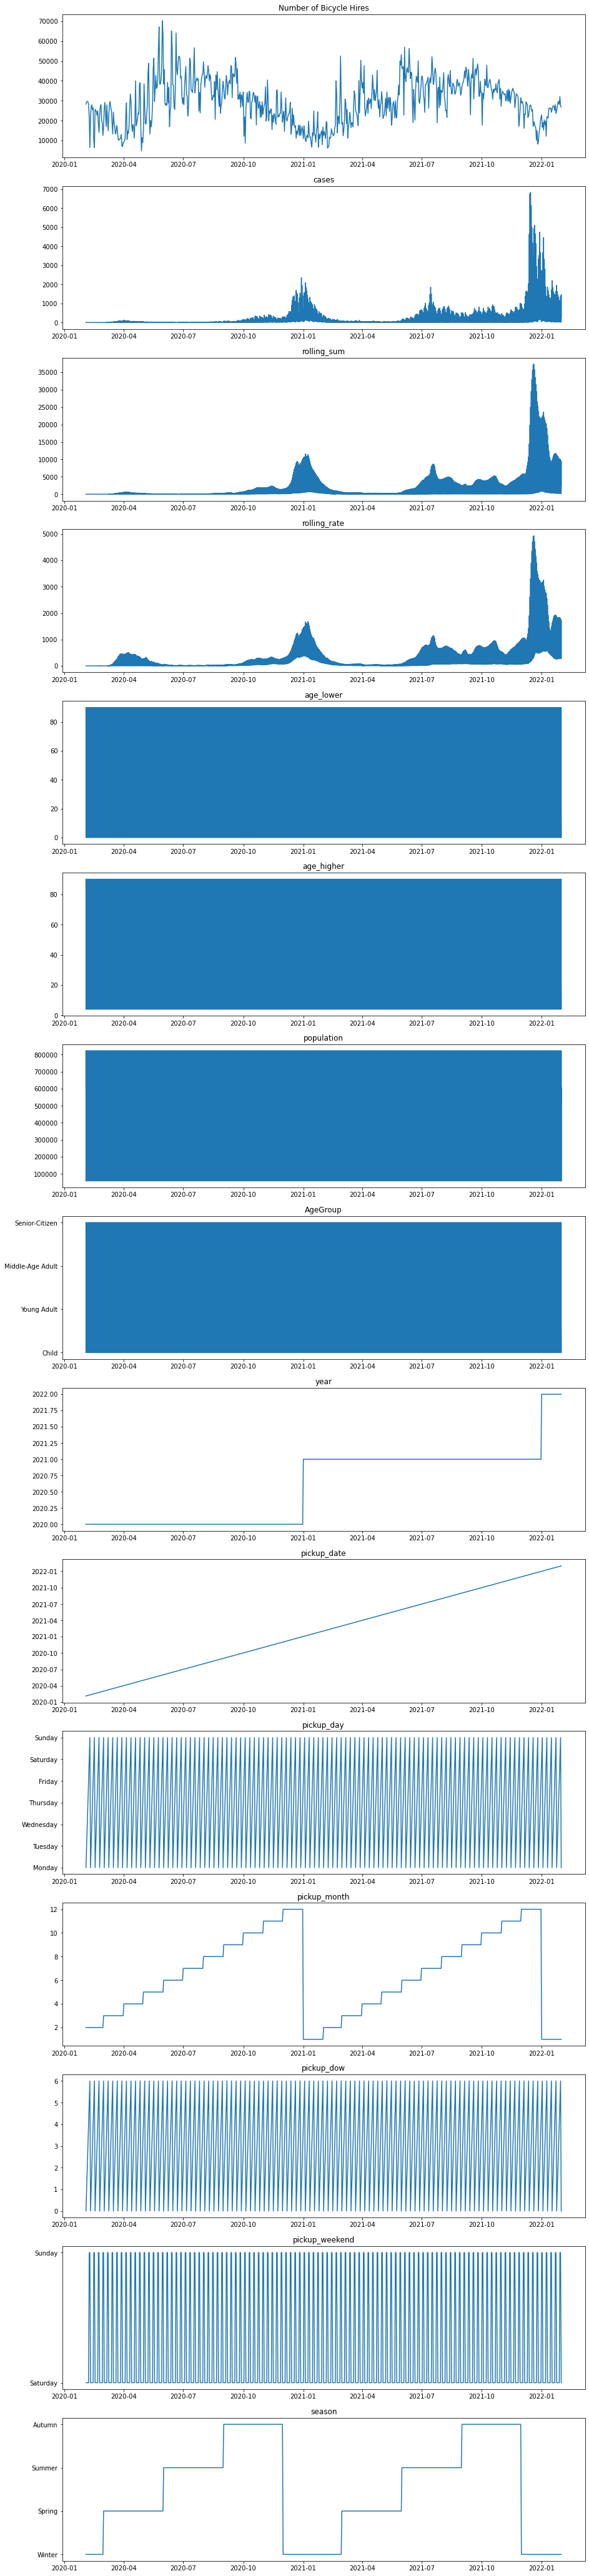

In [63]:
#Plotting pickups per day
plt.figure(figsize=(15, 75))
counter = 1
for col in bike_rentals_covid.columns:
    ax = plt.subplot(len(bike_rentals_covid.columns), 1, counter)
    ax.set_title(col)
    plt.plot(bike_rentals_covid['pickup_date'], bike_rentals_covid[col])
    counter = counter + 1

Text(0.5, 1.0, 'Hires per season')

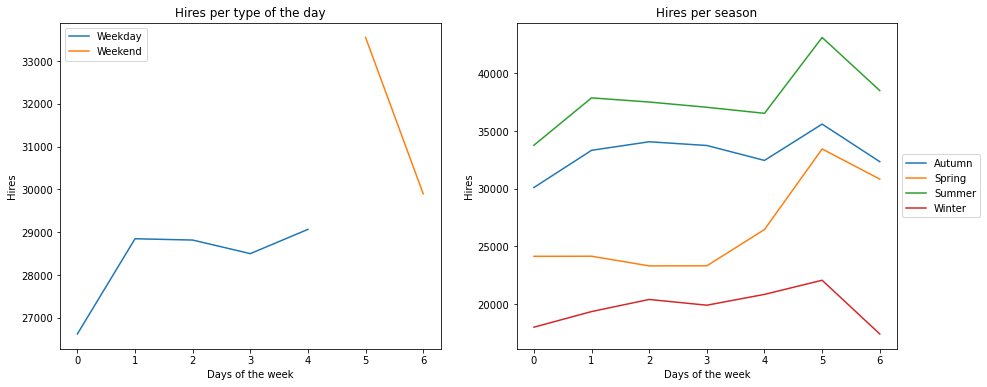

In [21]:
#Plotting pickups based on the type of the day and the season
 
fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))
#ax = plt.gca()
for weekday in covid_hires_per_dow['pickup_weekend'].unique():
    covid_hires_per_dow[covid_hires_per_dow.pickup_weekend==weekday].plot(kind='line',x='pickup_dow',y='Number of Bicycle Hires',ax=axes[0],xlabel='Days of the week',ylabel='Hires')
axes[0].legend(['Weekday','Weekend'])
axes[0].set_title('Hires per type of the day')



for season in covid_hires_per_season['season'].unique():
    covid_hires_per_season[covid_hires_per_season.season==season].plot(kind='line',x='pickup_dow',y='Number of Bicycle Hires',ax=axes[1],xlabel='Days of the week',ylabel='Hires')
axes[1].legend(covid_hires_per_season['season'].unique(),loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Hires per season')

In [22]:
covid_cases_per_agegroup=bike_rentals_covid.groupby(['pickup_dow','AgeGroup']).mean()['cases'].reset_index()
covid_cases_per_agegroup

,pickup_dow,AgeGroup,cases
0,0,Child,195.355556
1,0,Young Adult,348.917460
2,0,Middle-Age Adult,300.622222
3,0,Senior-Citizen,51.619048
4,1,Child,177.163462
5,1,Young Adult,363.884615
6,1,Middle-Age Adult,299.600962
7,1,Senior-Citizen,50.391484
8,2,Child,168.230769
9,2,Young Adult,366.371795


Text(0.5, 1.0, 'Covid-19 cases per day of the week per age group')

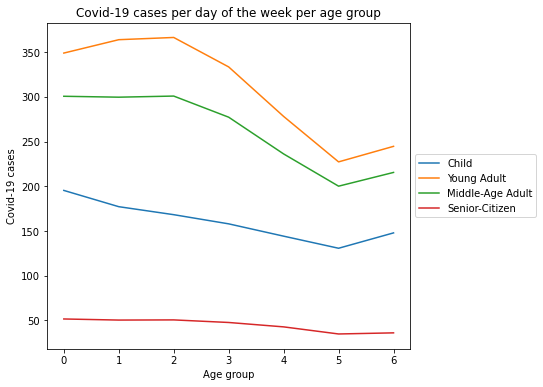

In [23]:
ax = plt.gca()
for agegroup in covid_cases_per_agegroup['AgeGroup'].unique():
    covid_cases_per_agegroup[covid_cases_per_agegroup.AgeGroup==agegroup].plot(kind='line',x='pickup_dow',y='cases',ax=ax,xlabel='Age group',ylabel='Covid-19 cases',figsize=(6.5,6))
plt.legend(covid_cases_per_agegroup['AgeGroup'].unique(),loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Covid-19 cases per day of the week per age group')

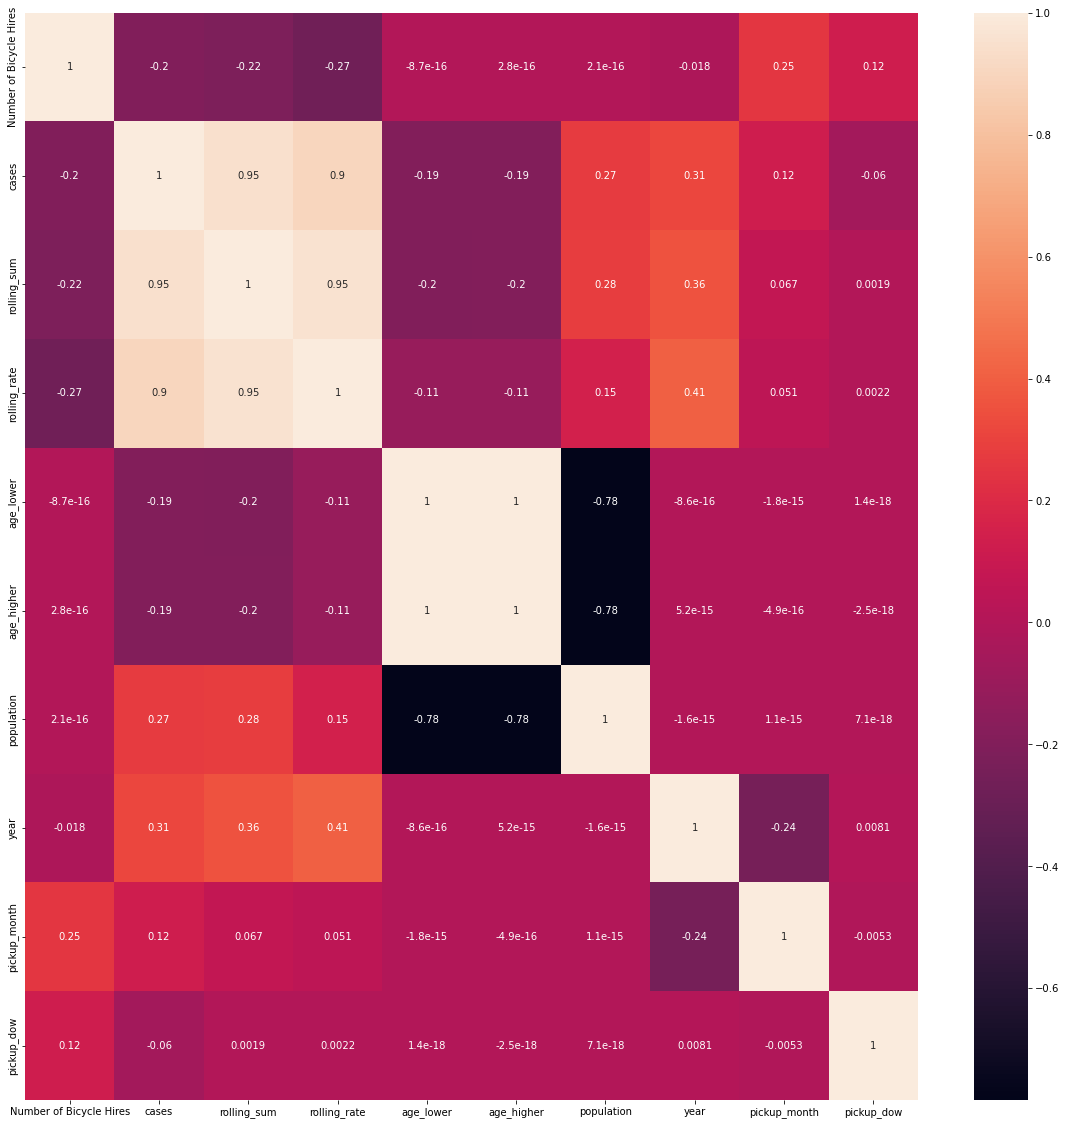

In [24]:
corrMatrix = bike_rentals_covid.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [25]:
cycling_load = json.load(open(Path.cwd().parent/"Assignment3"/"files"/"cycling-load.json"))

# insert loop here to download and concate data
tfl = pd.read_csv(cycling_load['entries'][1]['url'])

In [56]:
tfl = pd.DataFrame(tfl)
tfl

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
0,51053344,60,8158,24/01/2016 00:01,465.0,"Pitfield Street North,Hoxton",24/01/2016 00:00,569,"Pitfield Street Central, Hoxton"
1,51053345,1440,6975,24/01/2016 00:24,201.0,"Dorset Square, Marylebone",24/01/2016 00:00,430,"South Parade, Chelsea"
2,51053346,1860,11995,24/01/2016 00:31,584.0,"Ilchester Gardens, Bayswater",24/01/2016 00:00,335,"Tavistock Street, Covent Garden"
3,51053347,240,8268,24/01/2016 00:04,218.0,"St. Luke's Church, Chelsea",24/01/2016 00:00,589,"Drayton Gardens, West Chelsea"
4,51053348,1680,12776,24/01/2016 00:29,340.0,"Bank of England Museum, Bank",24/01/2016 00:01,238,"Frampton Street, Paddington"
...,...,...,...,...,...,...,...,...,...
292694,51360634,600,10400,07/02/2016 00:07,48.0,"Godliman Street, St. Paul's",06/02/2016 23:57,388,"Southampton Street, Strand"
292695,51360635,240,2320,07/02/2016 00:01,574.0,"Eagle Wharf Road, Hoxton",06/02/2016 23:57,73,"Old Street Station, St. Luke's"
292696,51360636,720,11143,07/02/2016 00:09,535.0,"Gloucester Avenue, Camden Town",06/02/2016 23:57,109,"Soho Square , Soho"
292697,51360637,900,6848,07/02/2016 00:14,732.0,"Duke Street Hill, London Bridge",06/02/2016 23:59,443,"Philpot Street, Whitechapel"


In [27]:
bikepoint = json.load(open(Path.cwd().parent/"Assignment3"/"files"/"bikepoint.json"))

In [28]:
bikepoint = pd.DataFrame(bikepoint)
bikepoint = bikepoint.drop(['$type', 'url', 'placeType', 'additionalProperties', 'children', 'childrenUrls'], axis='columns')
bikepoint

,id,commonName,lat,lon
0,BikePoints_1,"River Street , Clerkenwell",51.529163,-0.109970
1,BikePoints_2,"Phillimore Gardens, Kensington",51.499606,-0.197574
2,BikePoints_3,"Christopher Street, Liverpool Street",51.521283,-0.084605
3,BikePoints_4,"St. Chad's Street, King's Cross",51.530059,-0.120973
4,BikePoints_5,"Sedding Street, Sloane Square",51.493130,-0.156876
...,...,...,...,...
786,BikePoints_692,"Cadogan Close, Victoria Park",51.542118,-0.028941
787,BikePoints_693,"Felsham Road, Putney",51.464786,-0.215618
788,BikePoints_694,"Putney Rail Station, Putney",51.460717,-0.216526
789,BikePoints_695,"Islington Green, Angel",51.536384,-0.102757


In [29]:
list_id = list(range(1,len(bikepoint)+1))
bikepoint['id'] = list_id
bikepoint

,id,commonName,lat,lon
0,1,"River Street , Clerkenwell",51.529163,-0.109970
1,2,"Phillimore Gardens, Kensington",51.499606,-0.197574
2,3,"Christopher Street, Liverpool Street",51.521283,-0.084605
3,4,"St. Chad's Street, King's Cross",51.530059,-0.120973
4,5,"Sedding Street, Sloane Square",51.493130,-0.156876
...,...,...,...,...
786,787,"Cadogan Close, Victoria Park",51.542118,-0.028941
787,788,"Felsham Road, Putney",51.464786,-0.215618
788,789,"Putney Rail Station, Putney",51.460717,-0.216526
789,790,"Islington Green, Angel",51.536384,-0.102757


In [30]:
data = pd.merge(tfl, bikepoint, left_on="StartStation Id", right_on="id")
data = data.rename(columns={'id': 'id_start', 'lon' : 'lon_start', 'lat' : 'lat_start'})
data = pd.merge(data, bikepoint, left_on="EndStation Id", right_on="id")
data = data.rename(columns={'id': 'id_end', 'lon' : 'lon_end', 'lat' : 'lat_end'})
#data = data.dropna()
data.isnull().sum()

Rental Id            0
Duration             0
Bike Id              0
End Date             0
EndStation Id        0
EndStation Name      0
Start Date           0
StartStation Id      0
StartStation Name    0
id_start             0
commonName_x         0
lat_start            0
lon_start            0
id_end               0
commonName_y         0
lat_end              0
lon_end              0
dtype: int64

In [50]:
data

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,id_start,commonName_x,lat_start,lon_start,id_end,commonName_y,lat_end,lon_end
0,51053344,60,8158,24/01/2016 00:01,465.0,"Pitfield Street North,Hoxton",24/01/2016 00:00,569,"Pitfield Street Central, Hoxton",569,"Arlington Road, Camden Town",51.539957,-0.145246,465,"Porchester Place, Paddington",51.514746,-0.165164
1,51058086,1500,472,24/01/2016 12:49,465.0,"Pitfield Street North,Hoxton",24/01/2016 12:24,569,"Pitfield Street Central, Hoxton",569,"Arlington Road, Camden Town",51.539957,-0.145246,465,"Porchester Place, Paddington",51.514746,-0.165164
2,51209656,180,10662,31/01/2016 01:29,465.0,"Pitfield Street North,Hoxton",31/01/2016 01:26,569,"Pitfield Street Central, Hoxton",569,"Arlington Road, Camden Town",51.539957,-0.145246,465,"Porchester Place, Paddington",51.514746,-0.165164
3,51218482,120,11115,31/01/2016 18:28,465.0,"Pitfield Street North,Hoxton",31/01/2016 18:26,569,"Pitfield Street Central, Hoxton",569,"Arlington Road, Camden Town",51.539957,-0.145246,465,"Porchester Place, Paddington",51.514746,-0.165164
4,51218648,60,5223,31/01/2016 18:41,465.0,"Pitfield Street North,Hoxton",31/01/2016 18:40,569,"Pitfield Street Central, Hoxton",569,"Arlington Road, Camden Town",51.539957,-0.145246,465,"Porchester Place, Paddington",51.514746,-0.165164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292678,51349604,420,12809,06/02/2016 10:23,494.0,"South Quay East, Canary Wharf",06/02/2016 10:16,473,"Millharbour, Millwall",473,"Ashley Place, Victoria",51.496160,-0.140947,494,"LMU Commercial Road, Whitechapel",51.514924,-0.066078
292679,51309546,429960,10107,09/02/2016 13:23,346.0,Mechanical Workshop Penton,04/02/2016 13:57,116,"Little Argyll Street, West End",116,"Waterloo Station 1, Waterloo",51.504027,-0.113864,346,"Gunmakers Lane, Old Ford",51.535179,-0.033380
292680,51056300,462360,4862,29/01/2016 19:18,346.0,Mechanical Workshop Penton,24/01/2016 10:52,694,"Putney Rail Station, Putney",694,"Sackville Street, Mayfair",51.510048,-0.138846,346,"Gunmakers Lane, Old Ford",51.535179,-0.033380
292681,51091821,429960,5211,30/01/2016 17:41,346.0,Mechanical Workshop Penton,25/01/2016 18:15,101,"Queen Street 1, Bank",101,"Howland Street, Fitzrovia",51.520994,-0.139016,346,"Gunmakers Lane, Old Ford",51.535179,-0.033380


In [ ]:
# Import street map
street_map = gpd.read_file(Path.cwd().parent/"Assignment3"/"London-wards-2014_ESRI"/'London_Ward_CityMerged.shp')

# Creating new dataframe for storing relevant data for geo-visualization
data_location=pd.DataFrame()

In [ ]:
#creating new column which contains combined latitude and longitude
data["location"]=list(zip(data["lat_start"], data["lon_start"]))

data_location["location"]=data["location"]
# Storing only unique location
data_location=data_location.apply(lambda col: col.drop_duplicates().reset_index(drop=True))
data_location=data_location.dropna()
# Caluclating how much each location is "visited" to get consumption
data_location["consumption"]=list(data["location"].value_counts())

In [ ]:
# Making empty lists to store longitude and latitude to be used for geopandas library instance .points_from_xy
longitude=[]
latitude=[]
for x, y in data_location["location"]:
    longitude.append(x)
    latitude.append(y)

# Designate coordinate system
crs = CRS(init="epsg:4544")
geometry=gpd.points_from_xy(latitude,longitude)
# Create GeoPandas dataframe
geometry=geometry
geo_data = gpd.GeoDataFrame(data_location,
 crs = crs,
 geometry = geometry)

In [ ]:
# Create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))
# Add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4,color='grey')
# Add geodataframe to axes
geo_data.plot(column='consumption',ax=ax,alpha=0.5, legend=True,markersize=10)
plt.title("Consumption of bike stations", fontsize=15,fontweight='bold')
# Set latitiude and longitude boundaries for map display
#plt.xlim(-74.02,-73.9)
#plt.ylim(40.64,40.84)
plt.show()

In [34]:
# storing geodataframe as api requests are limited

#routing_gdf.to_pickle(Path.cwd().parent/"Assignment3"/'routing_gdf')



# restoring geodataframe

routing_gdf = pd.read_pickle(Path.cwd().parent/"Assignment3"/'routing_distances_durations')

routing_gdf

,datetime,location_rental_start,location_rental_end,length [m],duration [min],import_iteration
0,10/01/2016 00:00,"(-0.122219, 51.51477)","(-0.027581, 51.526578)",7393,1873,0
1,10/01/2016 14:33,"(-0.19701, 51.473763)","(-0.027581, 51.526578)",14138,3489,1
2,14/01/2016 18:01,"(-0.19701, 51.473763)","(-0.027581, 51.526578)",14138,3489,2
3,20/01/2016 17:52,"(-0.096317, 51.526008)","(-0.027581, 51.526578)",5694,1450,3
4,22/01/2016 20:30,"(-0.096317, 51.526008)","(-0.027581, 51.526578)",5694,1450,4
...,...,...,...,...,...,...
795,17/01/2016 12:37,"(-0.119123, 51.519435)","(-0.103132, 51.498744)",3113,764,795
796,18/01/2016 09:44,"(-0.129925, 51.493072)","(-0.103132, 51.498744)",2429,640,796
797,19/01/2016 09:48,"(-0.129925, 51.493072)","(-0.103132, 51.498744)",2429,640,797
798,19/01/2016 13:43,"(-0.167894, 51.493184)","(-0.103132, 51.498744)",5359,1388,798


In [35]:
routing_gdf['datetime'] = pd.to_datetime(routing_gdf['datetime'])

In [36]:
routing_gdf['date']=routing_gdf.datetime.dt.date
routing_gdf['hour']=routing_gdf.datetime.dt.hour
routing_gdf['month']=routing_gdf.datetime.dt.month

In [37]:
routing_gdf

,datetime,location_rental_start,location_rental_end,length [m],duration [min],import_iteration,date,hour,month
0,2016-10-01 00:00:00,"(-0.122219, 51.51477)","(-0.027581, 51.526578)",7393,1873,0,2016-10-01,0,10
1,2016-10-01 14:33:00,"(-0.19701, 51.473763)","(-0.027581, 51.526578)",14138,3489,1,2016-10-01,14,10
2,2016-01-14 18:01:00,"(-0.19701, 51.473763)","(-0.027581, 51.526578)",14138,3489,2,2016-01-14,18,1
3,2016-01-20 17:52:00,"(-0.096317, 51.526008)","(-0.027581, 51.526578)",5694,1450,3,2016-01-20,17,1
4,2016-01-22 20:30:00,"(-0.096317, 51.526008)","(-0.027581, 51.526578)",5694,1450,4,2016-01-22,20,1
...,...,...,...,...,...,...,...,...,...
795,2016-01-17 12:37:00,"(-0.119123, 51.519435)","(-0.103132, 51.498744)",3113,764,795,2016-01-17,12,1
796,2016-01-18 09:44:00,"(-0.129925, 51.493072)","(-0.103132, 51.498744)",2429,640,796,2016-01-18,9,1
797,2016-01-19 09:48:00,"(-0.129925, 51.493072)","(-0.103132, 51.498744)",2429,640,797,2016-01-19,9,1
798,2016-01-19 13:43:00,"(-0.167894, 51.493184)","(-0.103132, 51.498744)",5359,1388,798,2016-01-19,13,1


In [38]:
routing_gdf['location_rental_start'] = routing_gdf['location_rental_start'].astype(str)
routing_gdf['location_rental_end'] = routing_gdf['location_rental_end'].astype(str)

<AxesSubplot:xlabel='duration [min]', ylabel='length [m]'>

<Figure size 1080x5400 with 0 Axes>

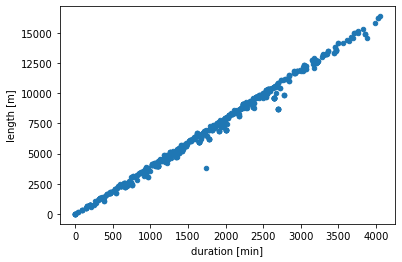

In [39]:
#Plotting length per day
plt.figure(figsize=(15, 75))
routing_gdf.plot.scatter(x='duration [min]', y='length [m]')

In [29]:
#routing_gdf = routing_gdf.drop(columns=['location_rental_start', 'location_rental_end'])
routing_gdf = routing_gdf.sort_values(by=['hour'])

In [40]:
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Legend, HoverTool, Title
from bokeh.io import output_notebook, show
from bokeh.models.tools import WheelZoomTool 

In [85]:
routing_gdf1 = routing_gdf.groupby(by=['hour']).agg({'duration [min]':'mean', 'length [m]':'mean'}).\
        reset_index()
routing_gdf1 = routing_gdf1.sort_values(by=['hour'])
routing_gdf1['duration'] = (routing_gdf['duration [min]']/60).astype(str)
routing_gdf1['length'] = routing_gdf1['length [m]']/1000
routing_gdf1

,hour,duration [min],length [m],duration,length
0,0,2023.800000,7430.200000,31.216666666666665,7.430200
1,1,968.500000,3584.000000,58.15,3.584000
2,2,664.000000,2522.000000,58.15,2.522000
3,5,2804.000000,10194.000000,24.166666666666668,10.194000
4,6,1190.600000,4678.550000,24.166666666666668,4.678550
5,7,1678.345455,6450.145455,41.21666666666667,6.450145
6,8,1837.320000,7078.160000,30.816666666666666,7.078160
7,9,2005.051282,7843.948718,30.816666666666666,7.843949
8,10,1627.926829,6256.853659,30.816666666666666,6.256854
9,11,1829.097561,7173.560976,30.816666666666666,7.173561


In [86]:
routing_gdf1['hour'] = routing_gdf1['hour'].astype(str)

In [87]:
# plotting
p = figure(title="Trip duration per hour", width=500, height=500, tools='hover', toolbar_location=None, 
           x_range=routing_gdf1['hour'].unique())

#defining  the columns for each bar
bar_xy = ["duration"]
           
bar={}
items = []
for indx, i in enumerate(bar_xy):
    bar[i] = p.vbar(x='hour', top=i, bottom=0, width=0.5, source = routing_gdf1, legend_label=i)
    items.append((i,[bar[i]]))

     
p.add_tools(HoverTool(tooltips = [
    ("hour", "@hour"),
    ("duration", '@duration')
    ]))


show(p)
output_notebook()

Loading BokehJS ...

In [88]:
# plotting
p = figure(title="Trip length in km per hour", width=500, height=500, tools='hover', toolbar_location=None, 
           x_range=routing_gdf1['hour'].unique())

#defining  the columns for each bar
bar_xy = ["length"]
           
bar={}
items = []
for indx, i in enumerate(bar_xy):
    bar[i] = p.vbar(x='hour', top=i, bottom=0, width=0.5, source = routing_gdf1, legend_label=i)
    items.append((i,[bar[i]]))

     
p.add_tools(HoverTool(tooltips = [
    ("hour", "@hour"),
    ("length", '@length')
    ]))


show(p)
output_notebook()

Loading BokehJS ...

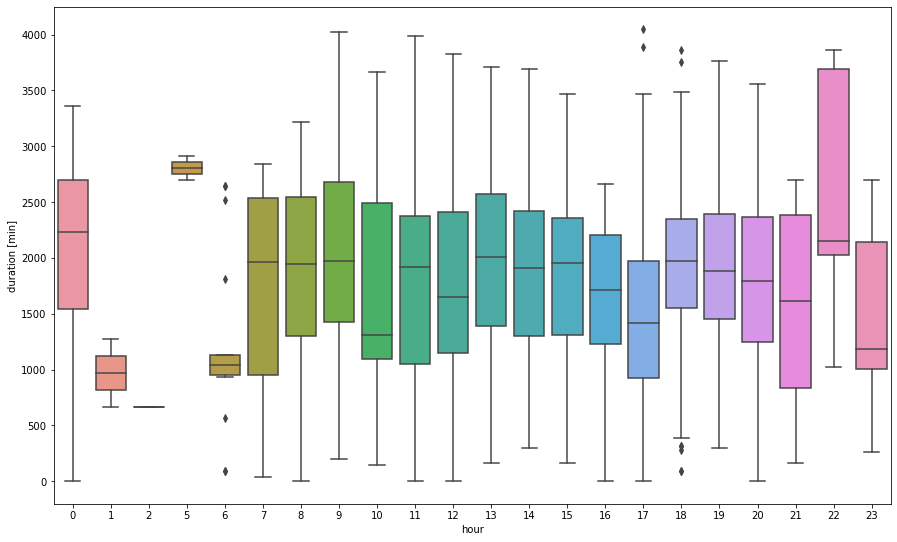

In [56]:
plt.figure(figsize=(15, 75))
counter = 1
ax = plt.subplot(len(routing_gdf.columns), 1, counter)
#plt.scatter(routing_gdf['hour'],routing_gdf['duration [min]'])
sns.boxplot(x=routing_gdf['hour'], y=routing_gdf['duration [min]'])
counter = counter + 1

In [92]:
routing_gdf1m = routing_gdf.groupby(by=['month']).agg({'duration [min]':'mean', 'length [m]':'mean'}).\
        reset_index()
routing_gdf1m = routing_gdf1m.sort_values(by=['month'])
routing_gdf1m['duration'] = (routing_gdf['duration [min]']/60).astype(str)
routing_gdf1m['length'] = (routing_gdf1m['length [m]']/1000).astype(str)
routing_gdf1m

,month,duration [min],length [m],duration,length
0,1,1792.951735,6975.117647,31.216666666666665,6.975117647058823
1,10,2116.259259,8349.333333,58.15,8.349333333333334
2,11,1718.076923,6700.884615,58.15,6.7008846153846156
3,12,1913.172414,7549.327586,24.166666666666668,7.549327586206897


In [95]:
routing_gdf1m['month'] = routing_gdf1m['month'].astype(str)
# plotting
p = figure(title="Trip duration in hours per month", width=500, height=500, tools='hover', toolbar_location=None, 
           x_range=routing_gdf1m['month'].unique())

#defining  the columns for each bar
bar_xy = ["duration"]
           
bar={}
items = []
for indx, i in enumerate(bar_xy):
    bar[i] = p.vbar(x='month', top=i, bottom=0, width=0.5, source = routing_gdf1m, legend_label=i)
    items.append((i,[bar[i]]))

     
p.add_tools(HoverTool(tooltips = [
    ("month", "@month"),
    ("duration", '@duration')
    ]))


show(p)
output_notebook()

Loading BokehJS ...

In [98]:
# plotting
p = figure(title="Trip duration per length per month", width=500, height=500, tools='hover', toolbar_location=None, 
           x_range=routing_gdf1m['month'].unique())

#defining  the columns for each bar
bar_xy = ["length"]
           
bar={}
items = []
for indx, i in enumerate(bar_xy):
    bar[i] = p.vbar(x='month', top=i, bottom=0, width=0.5, source = routing_gdf1m, legend_label=i)
    items.append((i,[bar[i]]))

     
p.add_tools(HoverTool(tooltips = [
    ("month", "@month"),
    ("length", "@length")
    ]))


show(p)
output_notebook()

Loading BokehJS ...

In [90]:
# plotting
p = figure(title="Trip length in km per month", width=500, height=500, tools='hover', toolbar_location=None, 
           x_range=routing_gdf1m['month'].unique())

#defining  the columns for each bar
bar_xy = ["length"]
           
bar={}
items = []
for indx, i in enumerate(bar_xy):
    bar[i] = p.vbar(x='month', top=i, bottom=0, width=0.5, source = routing_gdf1m, legend_label=i)
    items.append((i,[bar[i]]))

     
p.add_tools(HoverTool(tooltips = [
    ("month", "@month"),
    ("length", '@length')
    ]))


show(p)
output_notebook()

Loading BokehJS ...

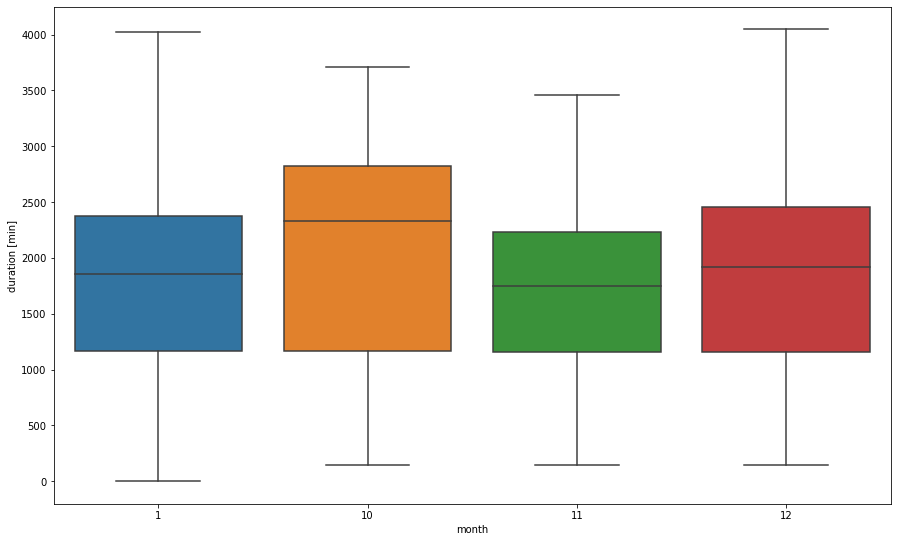

In [57]:
plt.figure(figsize=(15, 75))
counter = 1
ax = plt.subplot(len(routing_gdf.columns), 1, counter)
#plt.scatter(routing_gdf['hour'],routing_gdf['duration [min]'])
sns.boxplot(x=routing_gdf['month'], y=routing_gdf['duration [min]'])
counter = counter + 1

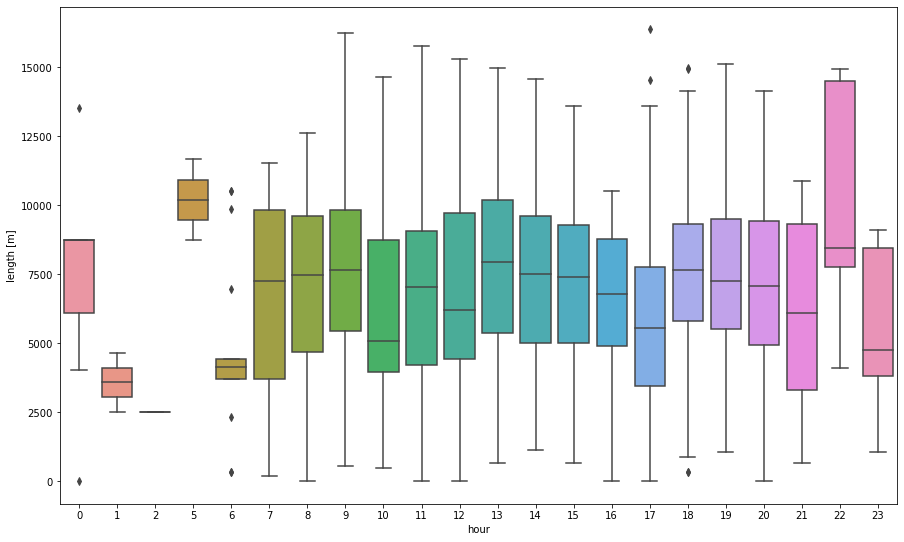

In [58]:
plt.figure(figsize=(15, 75))
counter = 1
ax = plt.subplot(len(routing_gdf.columns), 1, counter)
#plt.scatter(routing_gdf['hour'],routing_gdf['duration [min]'])
sns.boxplot(x=routing_gdf['hour'], y=routing_gdf['length [m]'])
counter = counter + 1

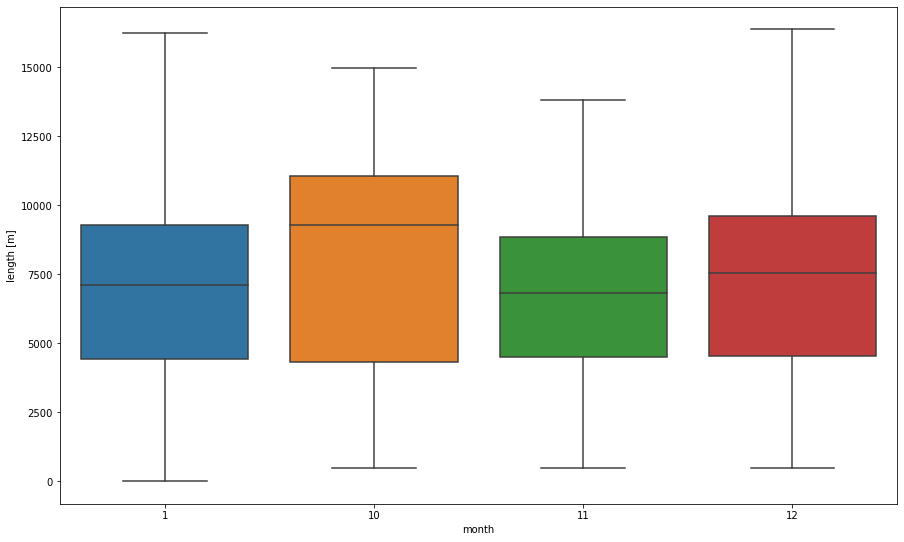

In [60]:
plt.figure(figsize=(15, 75))
counter = 1
ax = plt.subplot(len(routing_gdf.columns), 1, counter)
#plt.scatter(routing_gdf['hour'],routing_gdf['duration [min]'])
sns.boxplot(x=routing_gdf['month'], y=routing_gdf['length [m]'])
counter = counter + 1

In [124]:
routing_gdf_count = routing_gdf.groupby(by=['hour','date', 'length [m]', 'duration [min]']).agg({'date':'count'}).\
        rename(columns={'date':'count'}).reset_index()
routing_gdf_count

,hour,date,length [m],duration [min],count
0,0,2016-01-13,8750,2233,2
1,0,2016-01-14,8728,2695,1
2,0,2016-01-16,8728,2695,1
3,0,2016-01-16,13536,3364,1
4,0,2016-01-17,0,0,1
...,...,...,...,...,...
741,23,2016-01-19,8728,2695,1
742,23,2016-01-20,3522,989,1
743,23,2016-01-21,4089,1023,1
744,23,2016-01-22,8091,2174,1


In [125]:
routing_gdf_count = routing_gdf_count.rename(columns={'duration [min]':'duration','length [m]':'length'})
routing_gdf_count['duration'] = (routing_gdf_count['duration']/60).mean()
routing_gdf_count['length'] = (routing_gdf_count['length']/1000).mean()
routing_gdf_count['hour'] = routing_gdf_count['hour'].astype(str)
routing_gdf_count['duration'] = routing_gdf_count['duration'].astype(str)
routing_gdf_count['length'] = routing_gdf_count['length'].astype(str)
routing_gdf_count

,hour,date,length,duration,count
0,0,2016-01-13,6.986500000000001,29.88583556747104,2
1,0,2016-01-14,6.986500000000001,29.88583556747104,1
2,0,2016-01-16,6.986500000000001,29.88583556747104,1
3,0,2016-01-16,6.986500000000001,29.88583556747104,1
4,0,2016-01-17,6.986500000000001,29.88583556747104,1
...,...,...,...,...,...
741,23,2016-01-19,6.986500000000001,29.88583556747104,1
742,23,2016-01-20,6.986500000000001,29.88583556747104,1
743,23,2016-01-21,6.986500000000001,29.88583556747104,1
744,23,2016-01-22,6.986500000000001,29.88583556747104,1


In [126]:
# plotting
p = figure(title="Trips per hour", width=500, height=500, tools='hover', toolbar_location=None, 
           x_range=routing_gdf_count['hour'].unique())

#defining  the columns for each bar
bar_xy = ["count"]
           
bar={}
items = []
for indx, i in enumerate(bar_xy):
    bar[i] = p.vbar(x='hour', top=i, bottom=0, width=0.5, source = routing_gdf_count, legend_label=i)
    items.append((i,[bar[i]]))

p.add_tools(HoverTool(tooltips = [
    ("hour", "@hour"),
    ("length", '@length'),
    ("duration", "@duration"),
    ("count", "@count")
    ]))


show(p)
output_notebook()

Loading BokehJS ...